![TraderPy Logo](https://traderpy.files.wordpress.com/2021/01/cropped-logo3.png)

# Code an RSI Trading Startegy in Python

**Author**: TraderPy - Algorithmic Trading (Tu Khac Nguyen)

**Youtube**: https://www.youtube.com/channel/UC9xYCyyR_G3LIuJ_LlTiEVQ


## DISCLAIMER

Trading the financial markets imposes a risk of financial loss. TraderPy is not responsible for any financial losses that viewers suffer. Content is educational only and does not serve as financial advice. Information or material is provided ‘as is’ without any warranty. 

Past trading results do not indicate future performance. Strategies that worked in the past may not reflect the same results in the future.

---

## Introduction

In this Notebook, we will code and backtest an RSI Trading Strategy. RSI is a Technical Indicator used to find oversold and overbought prices and therefore is popular for mean reversion strategies

## Strategy Description

We will trade on the EURUSD daily timeframe. When the RSI indicator drops below 30 (oversold), we will buy and when RSI exceeds above 70 (overbought), we will sell.

For Exit, we will use the ATR Indicator. ATR measures the average range for each period and is therefore a good volatility indicator. After entering a trade, we will set take profit and stop loss to 2 ATR each

---

In [2]:
from finance.moving_averages.main import StockAnalyzer

In [4]:
# Libraries 
#import MetaTrader5 as mt5
import pandas as pd
import plotly.express as px

In [54]:
# connect to MetaTrader5 as mt5
mt5.initialize()

True

In [5]:
# settings
symbol = 'EURUSD'
#timeframe = mt5.TIMEFRAME_D1
start_pos = 0
num_bars = 1000

## Retrieving Historical Prices

In [56]:
# Requesting historical data
bars = mt5.copy_rates_from_pos(symbol, timeframe, start_pos, num_bars)
df = pd.DataFrame(bars)[['time', 'open', 'high', 'low', 'close']]
df.index = pd.to_datetime(df.index, unit='s')

df

,time,open,high,low,close
0,2018-01-16,1.22620,1.22834,1.21952,1.22602
1,2018-01-17,1.22589,1.23231,1.21771,1.21844
2,2018-01-18,1.21844,1.22652,1.21651,1.22391
3,2018-01-19,1.22366,1.22956,1.22150,1.22191
4,2018-01-22,1.22695,1.22722,1.22139,1.22618
...,...,...,...,...,...
995,2021-11-17,1.13203,1.13323,1.12635,1.13189
996,2021-11-18,1.13191,1.13742,1.13138,1.13729
997,2021-11-19,1.13673,1.13727,1.12501,1.12820
998,2021-11-22,1.12911,1.12911,1.12308,1.12338


In [23]:
df = StockAnalyzer(stock="EURUSD=X").get_historical_yf(start="2022-01-01")
df.columns = map(str.lower, df.columns)

In [24]:
df

,open,high,low,close,adj close,volume
Date,,,,,,
2022-01-03,1.137385,1.137592,1.128541,1.137346,1.137346,0
2022-01-04,1.130199,1.132300,1.127345,1.130224,1.130224,0
2022-01-05,1.128541,1.134559,1.127764,1.128363,1.128363,0
2022-01-06,1.131222,1.133067,1.128554,1.131350,1.131350,0
2022-01-07,1.129586,1.135976,1.129050,1.129688,1.129688,0
...,...,...,...,...,...,...
2023-10-10,1.057888,1.061954,1.055598,1.057888,1.057888,0
2023-10-11,1.060479,1.063355,1.059277,1.060479,1.060479,0
2023-10-12,1.062428,1.063909,1.054596,1.062428,1.062428,0


## Plotting EURUSD Close Prices

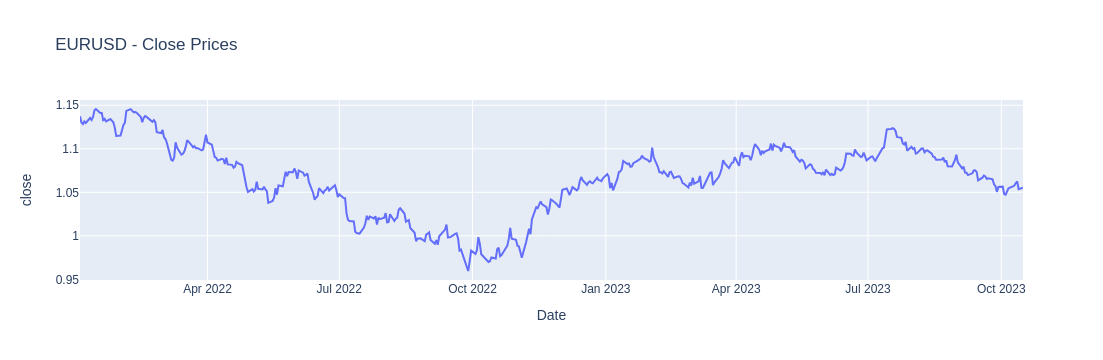

In [25]:
fig = px.line(df, x=df.index, y='close', title='EURUSD - Close Prices')  # creating a figure using px.line
display(fig)  # showing figure in output

## Calculating RSI Indicator

To find details how the indicator is calculated, watch this video: https://youtu.be/vT0-eLOw5Uk

,rsi_14,rs,ema_gain,ema_loss
Date,,,,
2022-01-03,NaN,NaN,NaN,NaN
2022-01-04,NaN,NaN,NaN,NaN
2022-01-05,NaN,NaN,NaN,NaN
2022-01-06,NaN,NaN,NaN,NaN
2022-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-10-10,100.0,3.186386e+12,1.301651e-17,4.085040e-30
2023-10-11,100.0,3.186386e+12,1.128098e-17,3.540368e-30
2023-10-12,100.0,3.186386e+12,9.776847e-18,3.068319e-30


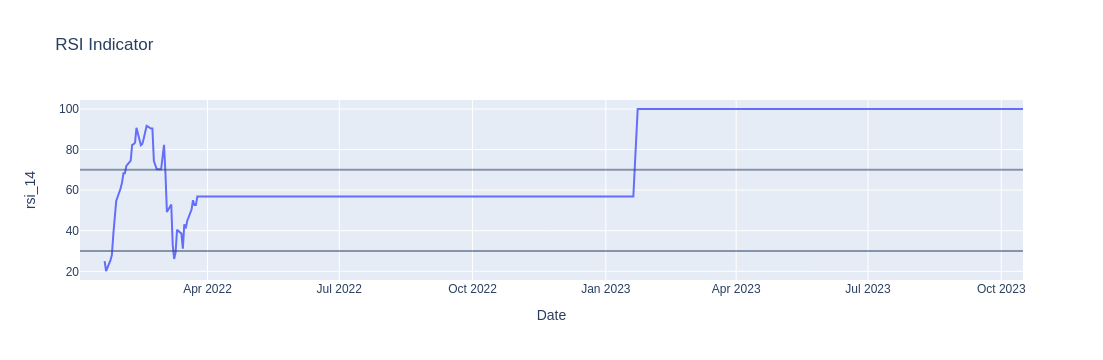

In [26]:
# setting the RSI Period
rsi_period = 14

# to calculate RSI, we first need to calculate the exponential weighted aveage gain and loss during the period
df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

# here we use the same formula to calculate Exponential Moving Average
df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()

# the Relative Strength is the ratio between the exponential avg gain divided by the exponential avg loss
df['rs'] = df['ema_gain'] / df['ema_loss']

# the RSI is calculated based on the Relative Strength using the following formula
df['rsi_14'] = 100 - (100 / (df['rs'] + 1))

# displaying the results
display(df[[ 'rsi_14', 'rs', 'ema_gain', 'ema_loss']])

# plotting the RSI
fig_rsi = px.line(df, x=df.index, y='rsi_14', title='RSI Indicator')

# RSI commonly uses oversold and overbought levels, usually at 70 and 30
overbought_level = 70
orversold_level = 30

# adding oversold and overbought levels to the plot
fig_rsi.add_hline(y=overbought_level, opacity=0.5)
fig_rsi.add_hline(y=orversold_level, opacity=0.5)

# showing the RSI Figure
display(fig_rsi)

## Calculating ATR Indicator

,atr_14
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2023-10-10,0.006648
2023-10-11,0.006550
2023-10-12,0.006813


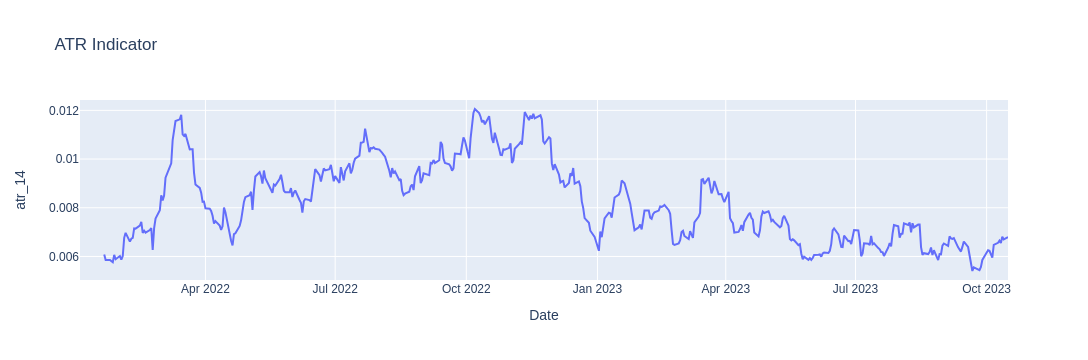

In [28]:
atr_period = 14  # defining the atr period to 14

# calculating the range of each candle
df['range'] = df['high'] - df['low']

# calculating the average value of ranges
df['atr_14'] = df['range'].rolling(atr_period).mean()

display(df[[ 'atr_14']])

# plotting the ATR Indicator
fig_atr = px.line(df, x=df.index, y='atr_14', title='ATR Indicator')
display(fig_atr)

## Importing classes for Backtesting

In [42]:
df['time']=df.index

In [43]:
# class Position contain data about trades opened/closed during the backtest 
class Position:
    def __init__(self, open_datetime, open_price, order_type, volume, sl, tp):
        self.open_datetime = open_datetime
        self.open_price = open_price
        self.order_type = order_type
        self.volume = volume
        self.sl = sl
        self.tp = tp
        self.close_datetime = None
        self.close_price = None
        self.profit = None
        self.status = 'open'
        
    def close_position(self, close_datetime, close_price):
        self.close_datetime = close_datetime
        self.close_price = close_price
        self.profit = (self.close_price - self.open_price) * self.volume if self.order_type == 'buy' \
                                                                        else (self.open_price - self.close_price) * self.volume
        self.status = 'closed'
        
    def _asdict(self):
        return {
            'open_datetime': self.open_datetime,
            'open_price': self.open_price,
            'order_type': self.order_type,
            'volume': self.volume,
            'sl': self.sl,
            'tp': self.tp,
            'close_datetime': self.close_datetime,
            'close_price': self.close_price,
            'profit': self.profit,
            'status': self.status,
        }
        

# class Strategy defines trading logic and evaluates the backtest based on opened/closed positions
class Strategy:
    def __init__(self, df, starting_balance):
        self.starting_balance = starting_balance
        self.positions = []
        self.data = df
    
    # return backtest result
    def get_positions_df(self):
        df = pd.DataFrame([position._asdict() for position in self.positions])
        df['pnl'] = df['profit'].cumsum() + self.starting_balance
        return df
    
    # add Position class to list
    def add_position(self, position):
        self.positions.append(position)
        return True
    
    # close positions when stop loss or take profit is reached
    def close_tp_sl(self, data):
        for pos in self.positions:
                    if pos.status == 'open':
                        if (pos.sl >= data.close and pos.order_type == 'buy'):
                            pos.close_position(data.time, pos.sl)
                        elif (pos.sl <= data.close and pos.order_type == 'sell'):
                            pos.close_position(data.time, pos.sl)
                        elif (pos.tp <= data.close and pos.order_type == 'buy'):
                            pos.close_position(data.time, pos.tp)
                        elif (pos.tp >= data.close and pos.order_type == 'sell'):
                            pos.close_position(data.time, pos.tp)
                            
    # check for open positions
    def has_open_positions(self):
        for pos in self.positions:
            if pos.status == 'open':
                return True
        return False
    
    # strategy logic how positions should be opened/closed
    def logic(self, data):
        
        # if no position is open
        if not self.has_open_positions():
            
            # if RSI less then 30 -> BUY
            if data['rsi_14'] < 30:
                
                # Position variables
                open_datetime = data['time']
                open_price = data['close']
                order_type = 'buy'
                volume = 10000
                sl = open_price - 2 * data['atr_14']
                tp = open_price + 2 * data['atr_14']
                
                self.add_position(Position(open_datetime, open_price, order_type, volume, sl, tp))
            
            # if RSI greater than 70 -> SELL
            elif data['rsi_14'] > 70:
                
                # Position variables
                open_datetime = data['time']
                open_price = data['close']
                order_type = 'sell'
                volume = 10000
                sl = open_price + 2 * data['atr_14']
                tp = open_price - 2 * data['atr_14']
                
                self.add_position(Position(open_datetime, open_price, order_type, volume, sl, tp))
        
        
# logic
    def run(self):
        # data represents a moment in time while iterating through the backtest
        for i, data in self.data.iterrows():
            # close positions when stop loss or take profit is reached
            self.close_tp_sl(data)
            
            # strategy logic
            self.logic(data)
        
        return self.get_positions_df()

In [38]:
# class Position contain data about trades opened/closed during the backtest 
class Position:
    def __init__(self, open_datetime, open_price, order_type, volume, sl, tp):
        self.open_datetime = open_datetime
        self.open_price = open_price
        self.order_type = order_type
        self.volume = volume
        self.sl = sl
        self.tp = tp
        self.close_datetime = None
        self.close_price = None
        self.profit = None
        self.status = 'open'
        
    def close_position(self, close_datetime, close_price):
        self.close_datetime = close_datetime
        self.close_price = close_price
        self.profit = (self.close_price - self.open_price) * self.volume if self.order_type == 'buy' \
                                                                        else (self.open_price - self.close_price) * self.volume
        self.status = 'closed'
        
    def _asdict(self):
        return {
            'open_datetime': self.open_datetime,
            'open_price': self.open_price,
            'order_type': self.order_type,
            'volume': self.volume,
            'sl': self.sl,
            'tp': self.tp,
            'close_datetime': self.close_datetime,
            'close_price': self.close_price,
            'profit': self.profit,
            'status': self.status,
        }
        

# class Strategy defines trading logic and evaluates the backtest based on opened/closed positions
class Strategy:
    def __init__(self, df, starting_balance):
        self.starting_balance = starting_balance
        self.positions = []
        self.data = df
    
    # return backtest result
    def get_positions_df(self):
        df = pd.DataFrame([position._asdict() for position in self.positions])
        df['pnl'] = df['profit'].cumsum() + self.starting_balance
        return df
    
    # add Position class to list
    def add_position(self, position):
        self.positions.append(position)
        return True
    
    # close positions when stop loss or take profit is reached
    def close_tp_sl(self, data):
        for pos in self.positions:
                    if pos.status == 'open':
                        if (pos.sl >= data.close and pos.order_type == 'buy'):
                            pos.close_position(data.index, pos.sl)
                        elif (pos.sl <= data.close and pos.order_type == 'sell'):
                            pos.close_position(data.index, pos.sl)
                        elif (pos.tp <= data.close and pos.order_type == 'buy'):
                            pos.close_position(data.index, pos.tp)
                        elif (pos.tp >= data.close and pos.order_type == 'sell'):
                            pos.close_position(data.index, pos.tp)
                            
    # check for open positions
    def has_open_positions(self):
        for pos in self.positions:
            if pos.status == 'open':
                return True
        return False
    
    # strategy logic how positions should be opened/closed
    def logic(self, data):
        
        # if no position is open
        if not self.has_open_positions():
            
            # if RSI less then 30 -> BUY
            if data['rsi_14'] < 30:
                
                # Position variables
                open_datetime = data.index
                open_price = data['close']
                order_type = 'buy'
                volume = 10000
                sl = open_price - 2 * data['atr_14']
                tp = open_price + 2 * data['atr_14']
                
                self.add_position(Position(open_datetime, open_price, order_type, volume, sl, tp))
            
            # if RSI greater than 70 -> SELL
            elif data['rsi_14'] > 70:
                
                # Position variables
                open_datetime = data.index
                open_price = data['close']
                order_type = 'sell'
                volume = 10000
                sl = open_price + 2 * data['atr_14']
                tp = open_price - 2 * data['atr_14']
                
                self.add_position(Position(open_datetime, open_price, order_type, volume, sl, tp))
        
        
# logic
    def run(self):
        # data represents a moment in time while iterating through the backtest
        for i, data in self.data.iterrows():
            # close positions when stop loss or take profit is reached
            self.close_tp_sl(data)
            
            # strategy logic
            self.logic(data)
        
        return self.get_positions_df()

In [44]:
# preparing data for backtest
backtest_df = df[14:]  # removing NaN values
backtest_df

,open,high,low,close,adj close,volume,gain,loss,ema_gain,ema_loss,rs,rsi_14,range,atr_14,time
Date,,,,,,,,,,,,,,,
2022-01-21,1.131542,1.136105,1.130224,1.131375,1.131375,0,0.000000,0.000166,2.603883e-05,1.031973e-04,2.523208e-01,20.148255,0.005881,0.005859,2022-01-21
2022-01-24,1.134095,1.134095,1.129140,1.134147,1.134147,0,0.000051,0.000000,2.981610e-05,8.788661e-05,3.392564e-01,25.331701,0.004956,0.005859,2022-01-24
2022-01-25,1.132387,1.132503,1.126684,1.132413,1.132413,0,0.000026,0.000000,2.920423e-05,7.504053e-05,3.891794e-01,28.015057,0.005818,0.005790,2022-01-25
2022-01-26,1.130352,1.131350,1.127205,1.130454,1.130454,0,0.000102,0.000000,3.973314e-05,6.421110e-05,6.187894e-01,38.225440,0.004145,0.005763,2022-01-26
2022-01-27,1.124227,1.124480,1.113350,1.124354,1.124354,0,0.000126,0.000000,5.211614e-05,5.504516e-05,9.467889e-01,48.633361,0.011130,0.006064,2022-01-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-10,1.057888,1.061954,1.055598,1.057888,1.057888,0,0.000000,0.000000,1.301651e-17,4.085040e-30,3.186386e+12,100.000000,0.006356,0.006648,2023-10-10
2023-10-11,1.060479,1.063355,1.059277,1.060479,1.060479,0,0.000000,0.000000,1.128098e-17,3.540368e-30,3.186386e+12,100.000000,0.004078,0.006550,2023-10-11
2023-10-12,1.062428,1.063909,1.054596,1.062428,1.062428,0,0.000000,0.000000,9.776847e-18,3.068319e-30,3.186386e+12,100.000000,0.009313,0.006813,2023-10-12


## Running the backtest

In [45]:
# creating an instance of Strategy class
rsi_strategy = Strategy(backtest_df, 10000)

# running the backtest
backtest_result = rsi_strategy.run()

backtest_result

,open_datetime,open_price,order_type,volume,sl,tp,close_datetime,close_price,profit,status,pnl
0,2022-01-21,1.131375,buy,10000,1.119657,1.143094,2022-01-28,1.119657,-117.186649,closed,9882.813351
1,2022-02-04,1.143576,sell,10000,1.157518,1.129634,2022-02-25,1.129634,139.416627,closed,10022.229978
2,2022-02-25,1.119069,sell,10000,1.134179,1.103959,2022-03-07,1.103959,151.102713,closed,10173.332691
3,2022-03-09,1.089823,buy,10000,1.068257,1.111390,2022-03-31,1.111390,215.666124,closed,10388.998815
4,2023-01-23,1.086508,sell,10000,1.103247,1.069768,2023-02-13,1.069768,167.395217,closed,10556.394032
5,2023-02-13,1.067771,sell,10000,1.083539,1.052004,2023-03-23,1.083539,-157.678127,closed,10398.715905
6,2023-03-23,1.087039,sell,10000,1.104537,1.069541,2023-04-14,1.104537,-174.982037,closed,10223.733868
7,2023-04-14,1.105461,sell,10000,1.120280,1.090642,2023-05-15,1.090642,148.188216,closed,10371.922084
8,2023-05-15,1.085270,sell,10000,1.099813,1.070726,2023-06-01,1.070726,145.432949,closed,10517.355033
9,2023-06-01,1.069519,sell,10000,1.081392,1.057646,2023-06-15,1.081392,-118.731260,closed,10398.623773


## Visualizing the Backtest

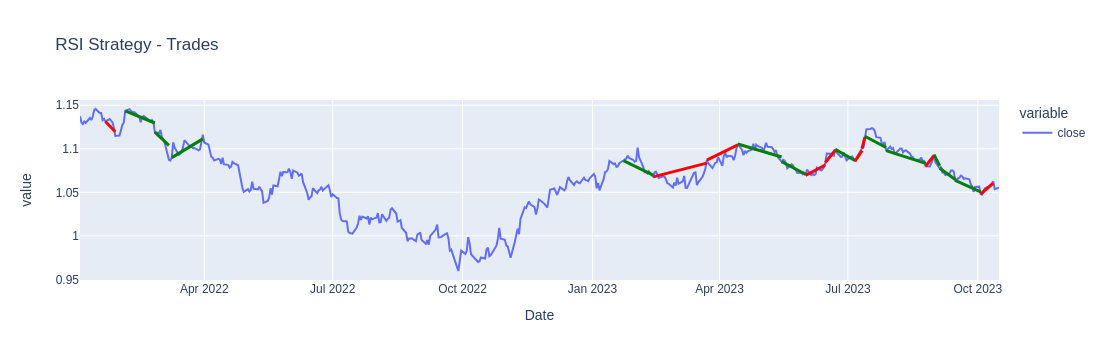

In [46]:
# analysing closed positions only
backtest_result = backtest_result[backtest_result['status'] == 'closed']

# visualizing trades
fig_backtest = px.line(df, x=df.index, y=['close'], title='RSI Strategy - Trades')

# adding trades to plots
for i, position in backtest_result.iterrows():
    if position.status == 'closed':
        fig_backtest.add_shape(type="line",
            x0=position.open_datetime, y0=position.open_price, x1=position.close_datetime, y1=position.close_price,
            line=dict(
                color="green" if position.profit >= 0 else "red",
                width=3)
            )

fig_backtest

## Plotting PnL

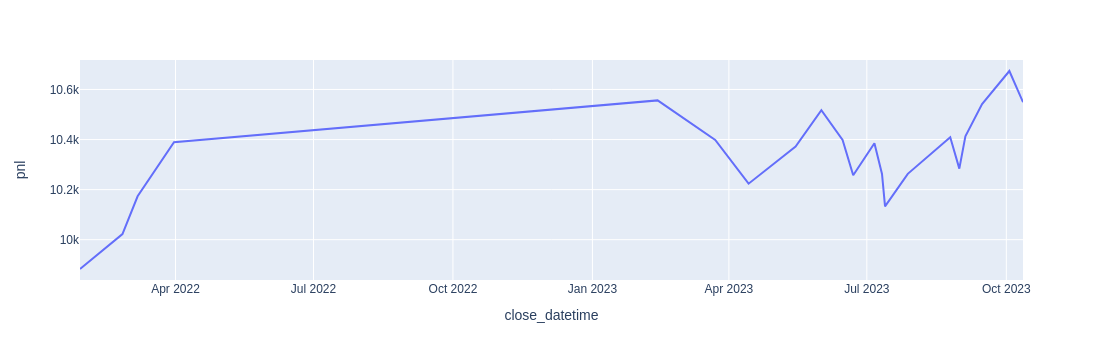

In [47]:
fig_pnl = px.line(backtest_result, x='close_datetime', y='pnl')
fig_pnl